In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
bank = pd.read_csv('bank_data_after_eda.csv')
bank = bank.drop(columns = 'Unnamed: 0')
bank.head()

,index,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,agerange,total_loan,contacted
0,0,56,housemaid,married,Basic,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Mid-age Adults,no,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Mid-age Adults,no,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Young Adults,housing,no
3,3,40,admin.,married,Basic,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Young Adults,no,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Mid-age Adults,personal,no


In [4]:
bank.shape

(41184, 23)

In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41184 entries, 0 to 41183
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           41184 non-null  int64  
 1   age             41184 non-null  int64  
 2   job             41184 non-null  object 
 3   marital         41184 non-null  object 
 4   education       41184 non-null  object 
 5   default         41184 non-null  object 
 6   housing         41184 non-null  object 
 7   loan            41184 non-null  object 
 8   contact         41184 non-null  object 
 9   month           41184 non-null  object 
 10  day_of_week     41184 non-null  object 
 11  campaign        41184 non-null  int64  
 12  previous        41184 non-null  int64  
 13  poutcome        41184 non-null  object 
 14  emp.var.rate    41184 non-null  float64
 15  cons.price.idx  41184 non-null  float64
 16  cons.conf.idx   41184 non-null  float64
 17  euribor3m       41184 non-null 

## Feature Engineering

According to EDA, some features have no affect on subscribe

In [6]:
no_effect = ['loan', 'housing', 'total_loan', 'day_of_week']

df = bank.drop(columns = no_effect)

Skew

In [7]:
#skew = ['campaign', 'previous']

df['campaign'] = np.log10(df['campaign'] + 1)
df['previous'] = np.log10(df['previous'] + 1)

#### Create Dummy

In [8]:
dummy = ['job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome', 'agerange', 'contacted']

df = pd.get_dummies(df, columns=dummy)

In [9]:
df = df.drop(columns = 'index')

### Correlation

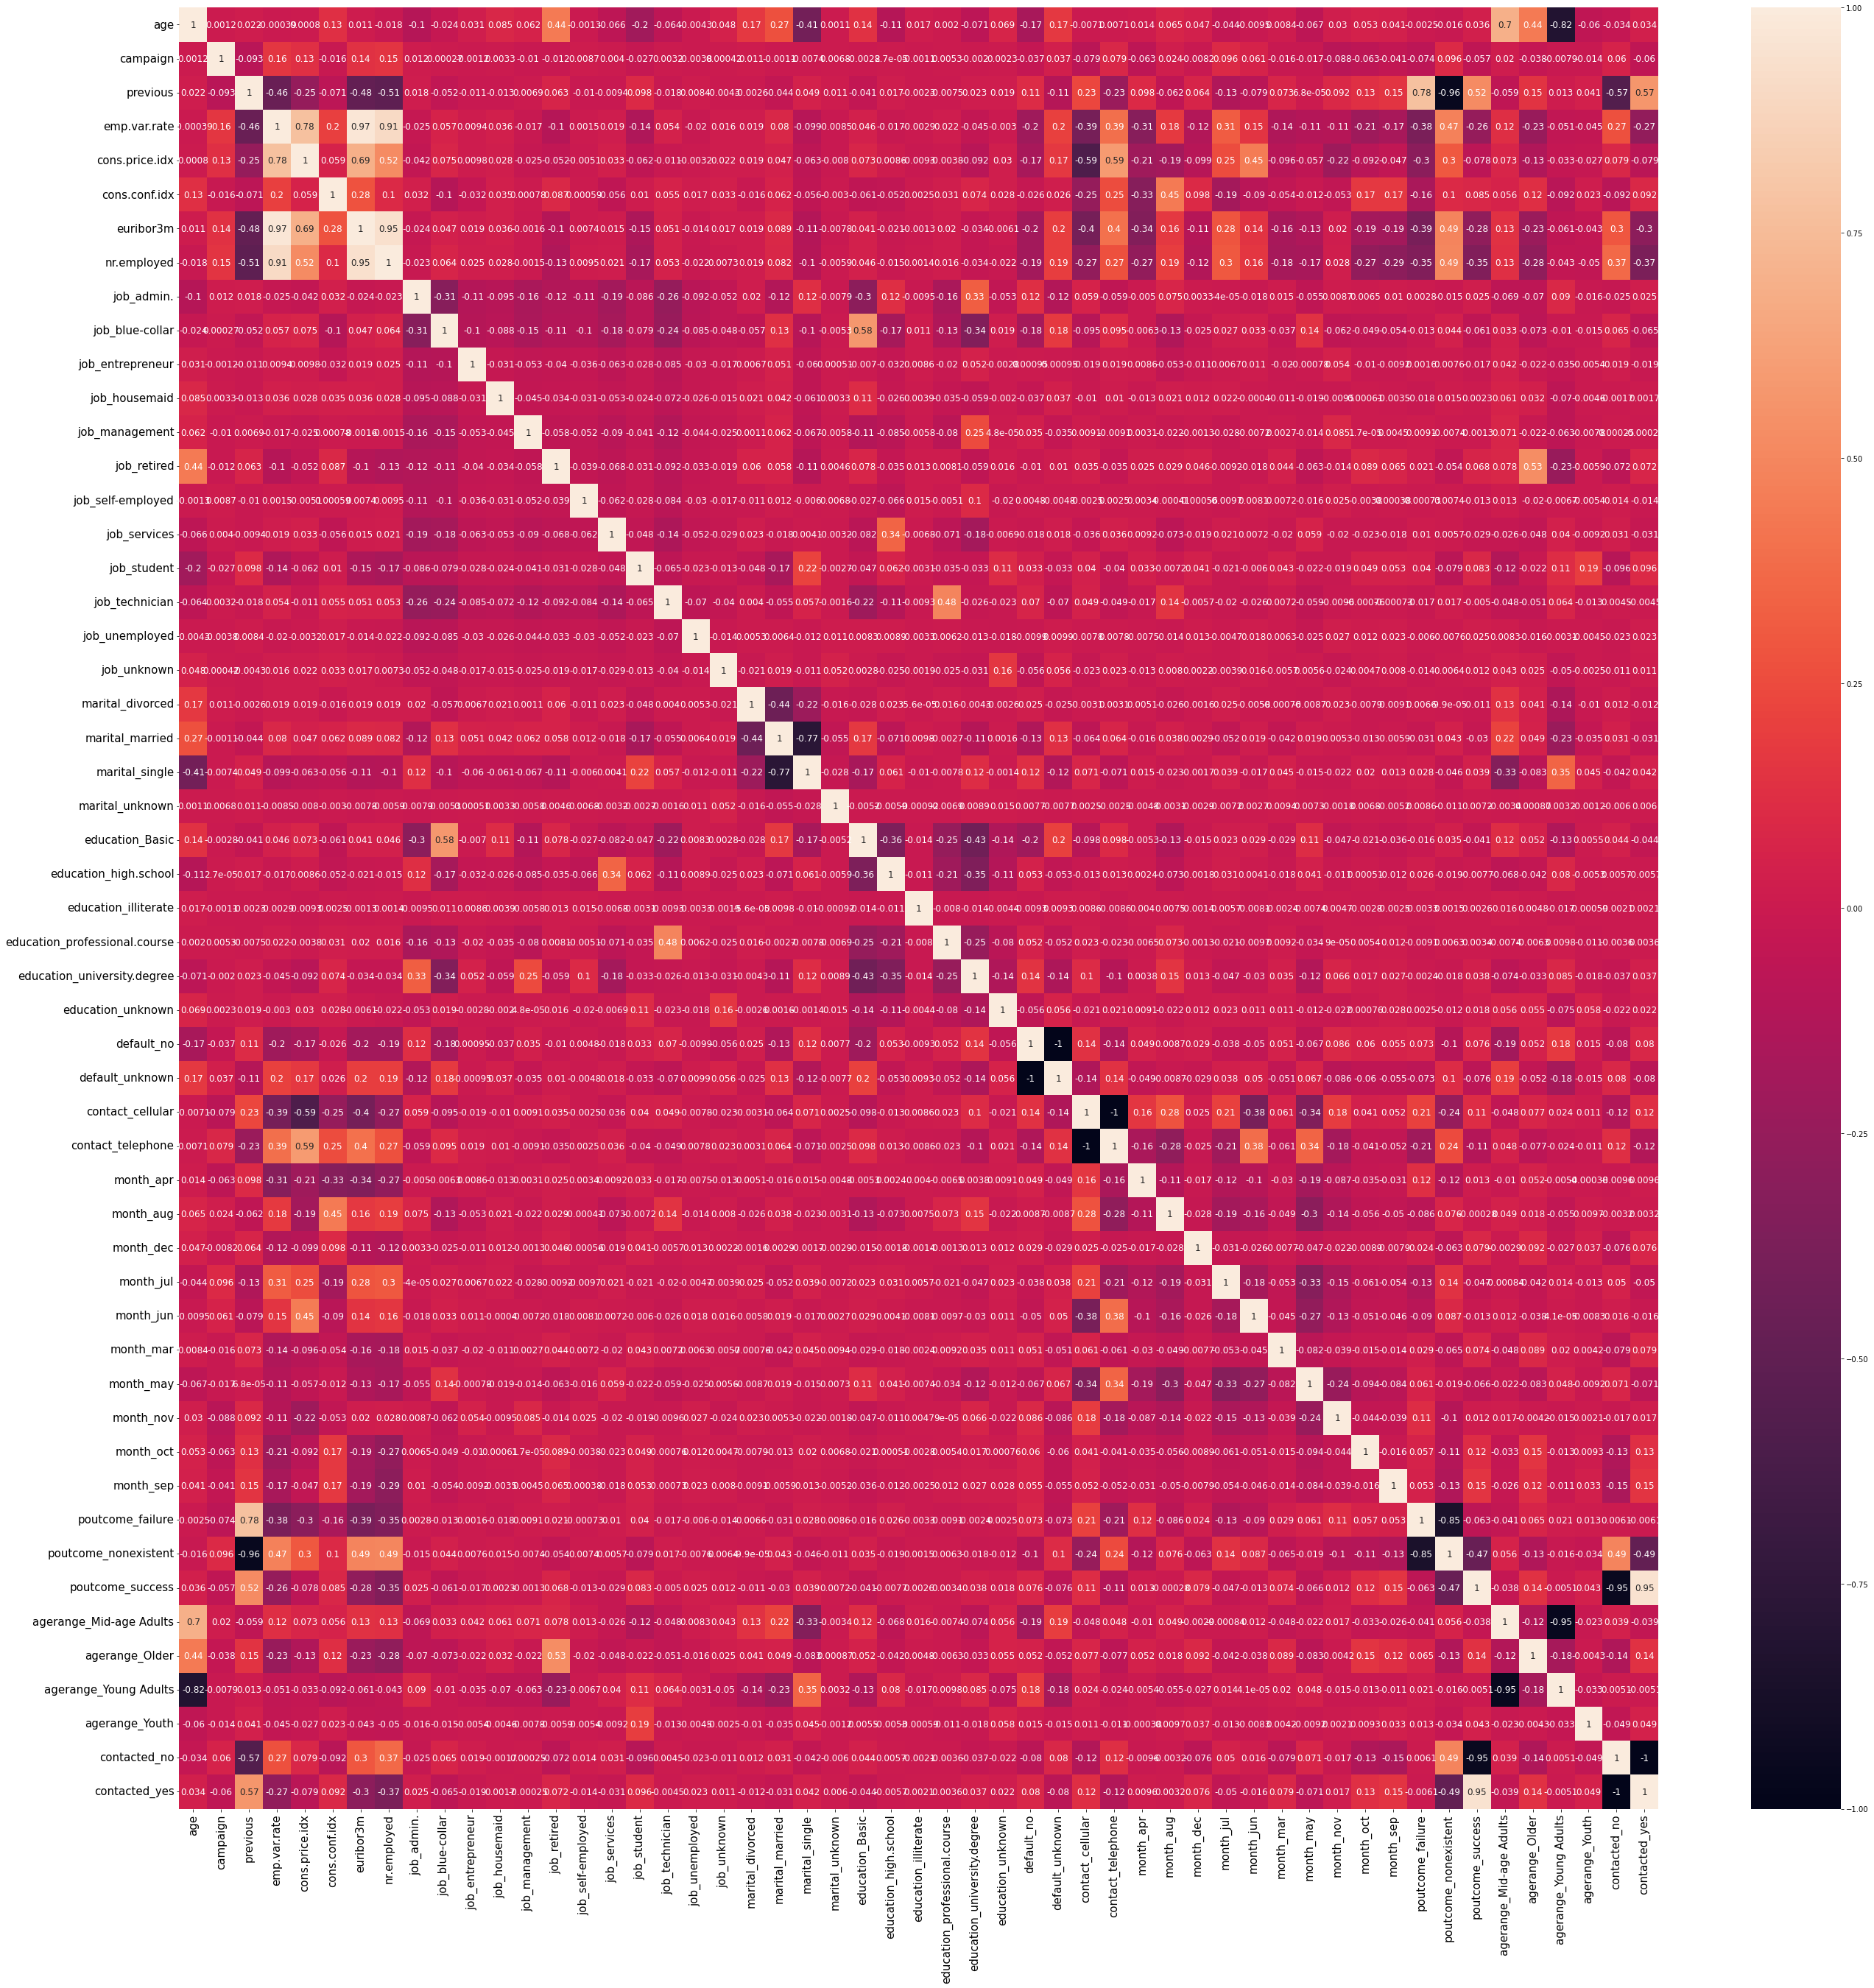

In [10]:
correlation = df.corr()

# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [11]:
#remove hifh correalted features
remove = ['emp.var.rate']
df = df.drop(columns = remove)

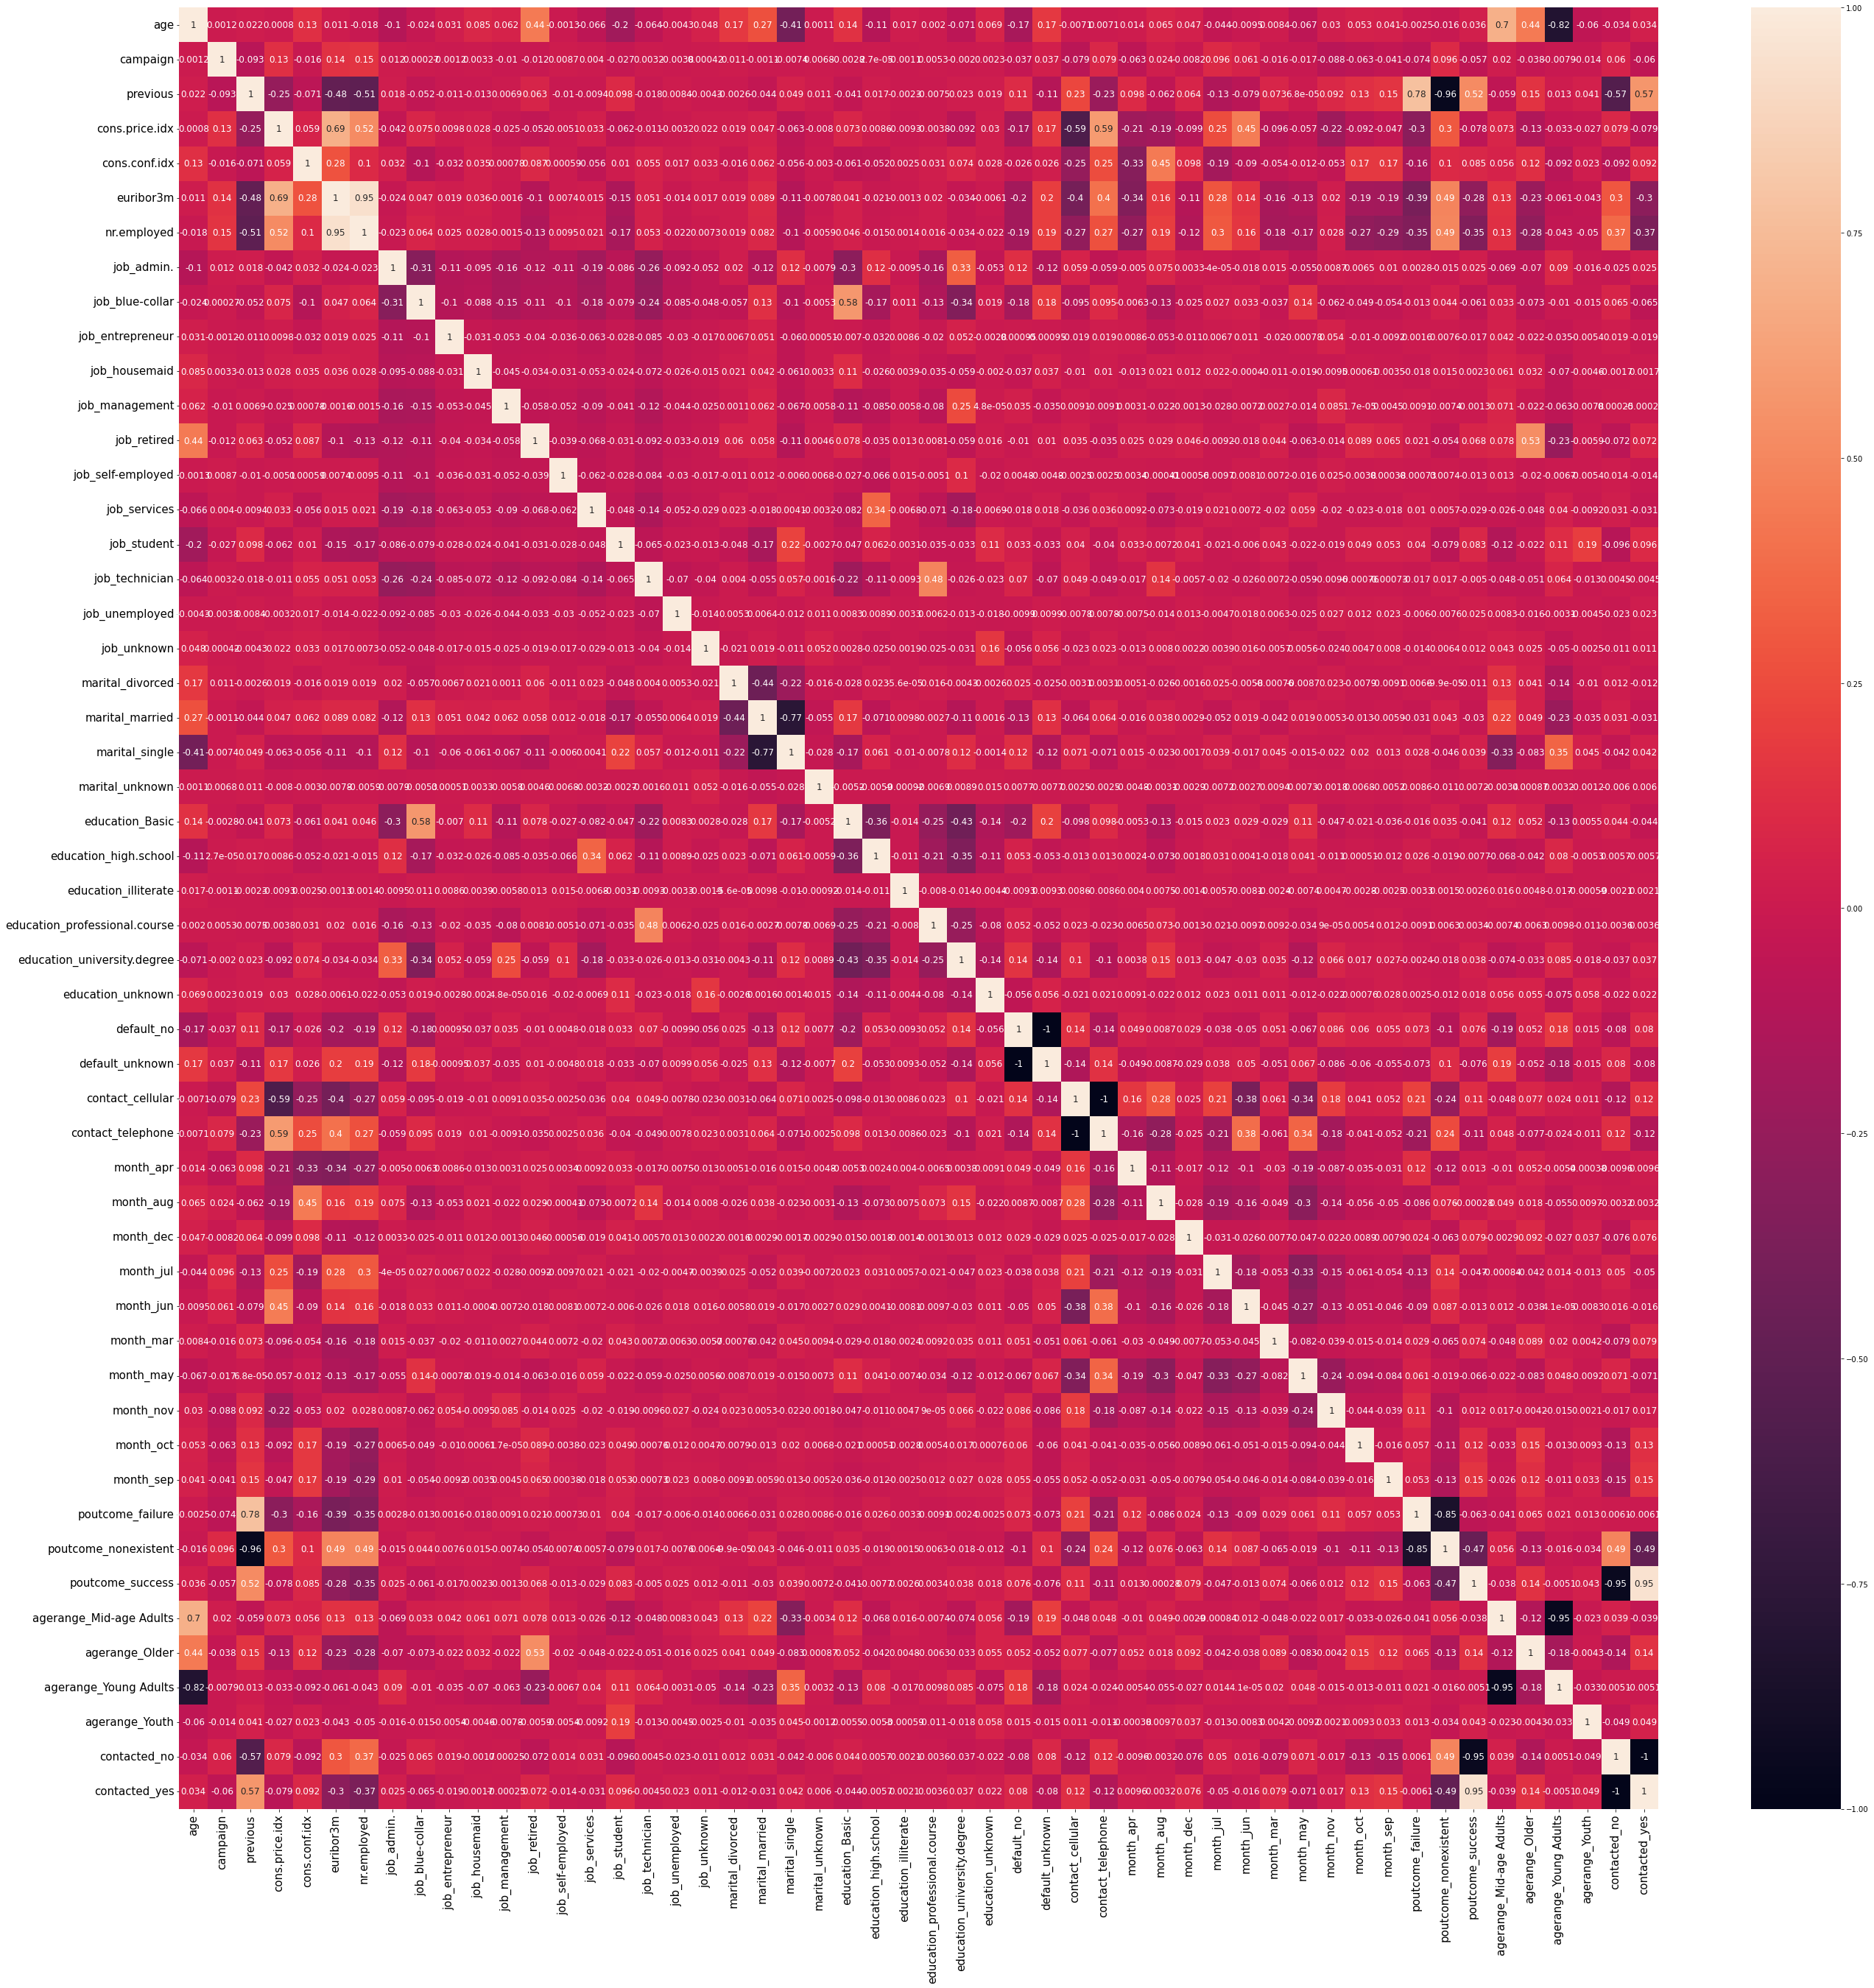

In [12]:
#check correlation again
corr2 = df.corr()

# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    corr2, 
    xticklabels=corr2.columns.values,
    yticklabels=corr2.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Imbalance Data

In [13]:
df.shape

(41184, 53)

In [14]:
df['y'].value_counts()

no     36544
yes     4640
Name: y, dtype: int64

#### Resampling

In [15]:
from sklearn.utils import resample

In [16]:
#create two different dataframe of majority and minority class 
df_majority = df[(df['y']== 'no')] 
df_minority = df[(df['y']== 'yes')] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 36544, # to match majority class
                                 random_state = 157)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [17]:
df_upsampled['y'].value_counts()

yes    36544
no     36544
Name: y, dtype: int64

#### SOMTE

Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model. In SMOTE new instances are synthesized from the existing data. If we explain it in simple words, SMOTE looks into minority class instances and use k nearest neighbor to select a random nearest neighbor, and a synthetic instance is created randomly in feature space.

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=157)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df.drop('y', axis=1), df['y'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [20]:
oversampled['y'].value_counts()

no     36544
yes    36544
Name: y, dtype: int64

# Modelling

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

#### Resampling

In [22]:
features = df_upsampled.drop(columns = 'y')
subscribe = df_upsampled['y']
subscribe = subscribe.map(dict(yes=1, no=0))

Xtrain, Xtest, ytrain, ytest = train_test_split(features, subscribe, test_size=0.3, random_state=157)
Xtrain.shape, Xtest.shape

((51161, 52), (21927, 52))

Train acc: 0.739704071460683
Test acc: 0.7348474483513476


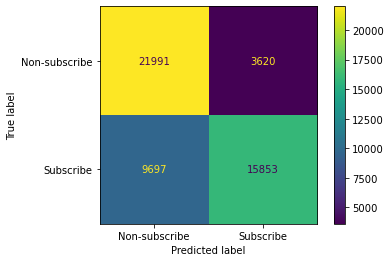

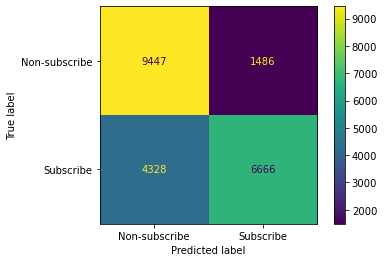

In [23]:
#logistic Regression
model = LogisticRegression(max_iter= 10000)

model.fit(Xtrain, ytrain)

pred_train = model.predict(Xtrain)
pred_test = model.predict(Xtest)

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, 
                                          display_labels = ['Non-subscribe','Subscribe'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, 
                                         display_labels = ['Non-subscribe','Subscribe'])
cm_display_test.plot()

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))

Train acc: 0.9859658724418991
Test acc: 0.9491038445751813


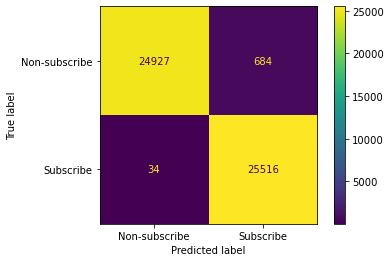

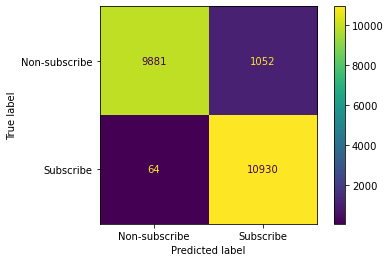

In [24]:
#random forest
model2 = RandomForestClassifier()

model2.fit(Xtrain, ytrain)

pred_train = model2.predict(Xtrain)
pred_test = model2.predict(Xtest)

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, 
                                          display_labels = ['Non-subscribe','Subscribe'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, 
                                         display_labels = ['Non-subscribe','Subscribe'])
cm_display_test.plot()

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))

In [43]:
#ANN
D = Xtrain.shape[1]
model3  = Sequential()
model3.add(Dense(100, activation = 'relu', input_shape = (D, )))
model3.add(Dense(100, activation = 'relu'))
model3.add(Dense(2, activation = 'sigmoid'))

In [44]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               5300      
                                                                 
 dense_19 (Dense)            (None, 100)               10100     
                                                                 
 dense_20 (Dense)            (None, 2)                 202       
                                                                 
Total params: 15,602
Trainable params: 15,602
Non-trainable params: 0
_________________________________________________________________


In [45]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [46]:
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model3.fit(Xtrain, ytrain, 
                          validation_data = (Xtest, ytest),
                          epochs = 50)

Epoch 1/50
1599/1599 [==============================] - 5s 3ms/step - loss: 3.3792 - accuracy: 0.5464 - val_loss: 0.7976 - val_accuracy: 0.6328
Epoch 2/50
1599/1599 [==============================] - 4s 2ms/step - loss: 1.2883 - accuracy: 0.6215 - val_loss: 0.8522 - val_accuracy: 0.7014
Epoch 3/50
1599/1599 [==============================] - 4s 3ms/step - loss: 1.0779 - accuracy: 0.6370 - val_loss: 1.2304 - val_accuracy: 0.6244
Epoch 4/50
1599/1599 [==============================] - 4s 3ms/step - loss: 0.8659 - accuracy: 0.6512 - val_loss: 0.6630 - val_accuracy: 0.7206
Epoch 5/50
1599/1599 [==============================] - 6s 3ms/step - loss: 0.8141 - accuracy: 0.6617 - val_loss: 0.9033 - val_accuracy: 0.5942
Epoch 6/50
1599/1599 [==============================] - 5s 3ms/step - loss: 0.7485 - accuracy: 0.6706 - val_loss: 0.9567 - val_accuracy: 0.5203
Epoch 7/50
1599/1599 [==============================] - 4s 3ms/step - loss: 0.7064 - accuracy: 0.6757 - val_loss: 0.9283 - val_accuracy:

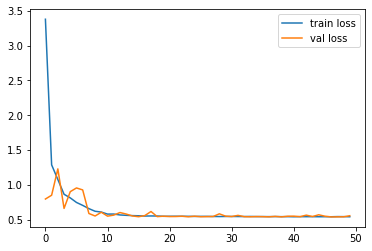

In [47]:
#plot loss per iteration
plt.plot(model_history.history['loss'], label = 'train loss')
plt.plot(model_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

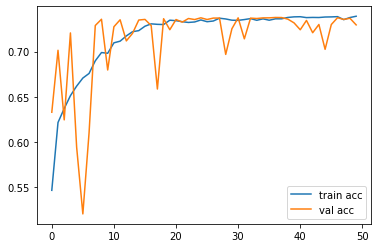

In [48]:
#accuracy per iteration
plt.plot(model_history.history['accuracy'], label = 'train acc')
plt.plot(model_history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();

In [50]:
acc_ann = model3.evaluate(Xtest, ytest)[1]

print(f'Accuracy of model is {acc_ann}')

686/686 [==============================] - 1s 2ms/step - loss: 0.5577 - accuracy: 0.7295
Accuracy of model is 0.7294659614562988


#### SMOTE

In [57]:
features = oversampled.drop(columns = 'y')
subscribe = oversampled['y']
subscribe = subscribe.map(dict(yes=1, no=0))

Xtrain, Xtest, ytrain, ytest = train_test_split(features, subscribe, test_size=0.3, random_state=157)
Xtrain.shape, Xtest.shape

((51161, 52), (21927, 52))

Train acc: 0.8913821074646704
Test acc: 0.8922333196515712


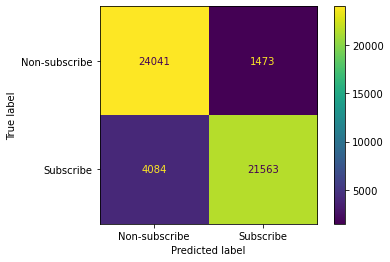

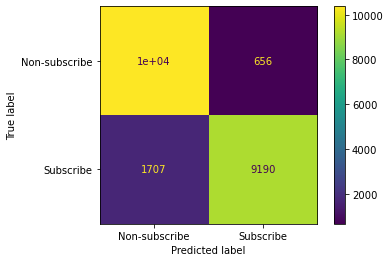

In [58]:
#LogisticRegression
model = LogisticRegression(max_iter= 10000)

model.fit(Xtrain, ytrain)

pred_train = model.predict(Xtrain)
pred_test = model.predict(Xtest)

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, 
                                          display_labels = ['Non-subscribe','Subscribe'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, 
                                         display_labels = ['Non-subscribe','Subscribe'])
cm_display_test.plot()

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))

Train acc: 0.9922401829518579
Test acc: 0.9298125598577097


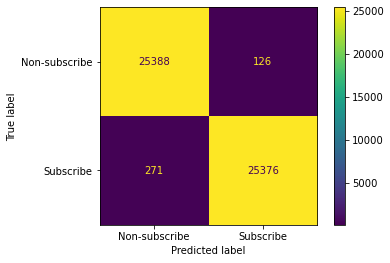

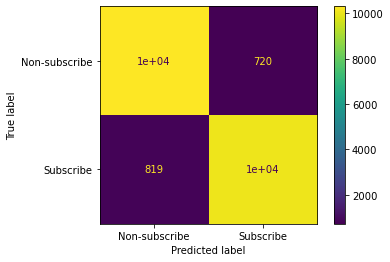

In [59]:
#random forest
model2 = RandomForestClassifier()

model2.fit(Xtrain, ytrain)

pred_train = model2.predict(Xtrain)
pred_test = model2.predict(Xtest)

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, 
                                          display_labels = ['Non-subscribe','Subscribe'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, 
                                         display_labels = ['Non-subscribe','Subscribe'])
cm_display_test.plot()

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))

In [60]:
#ANN
D = Xtrain.shape[1]
model4  = Sequential()
model4.add(Dense(100, activation = 'relu', input_shape = (D, )))
model4.add(Dense(100, activation = 'relu'))
model4.add(Dense(2, activation = 'sigmoid'))

In [61]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [63]:
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model4.fit(Xtrain, ytrain, 
                          validation_data = (Xtest, ytest),
                          epochs = 50)

Epoch 1/50
1599/1599 [==============================] - 4s 2ms/step - loss: 3.8972 - accuracy: 0.5711 - val_loss: 2.3638 - val_accuracy: 0.4970
Epoch 2/50
1599/1599 [==============================] - 4s 3ms/step - loss: 1.7972 - accuracy: 0.6569 - val_loss: 1.1768 - val_accuracy: 0.7341
Epoch 3/50
1599/1599 [==============================] - 4s 2ms/step - loss: 1.3659 - accuracy: 0.6974 - val_loss: 0.5248 - val_accuracy: 0.7907
Epoch 4/50
1599/1599 [==============================] - 5s 3ms/step - loss: 1.0740 - accuracy: 0.7117 - val_loss: 2.1755 - val_accuracy: 0.6318
Epoch 5/50
1599/1599 [==============================] - 8s 5ms/step - loss: 0.8313 - accuracy: 0.7368 - val_loss: 1.1654 - val_accuracy: 0.6960
Epoch 6/50
1599/1599 [==============================] - 5s 3ms/step - loss: 0.7249 - accuracy: 0.7603 - val_loss: 0.6174 - val_accuracy: 0.7846
Epoch 7/50
1599/1599 [==============================] - 5s 3ms/step - loss: 0.6504 - accuracy: 0.7711 - val_loss: 0.6623 - val_accuracy:

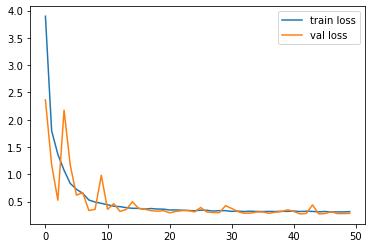

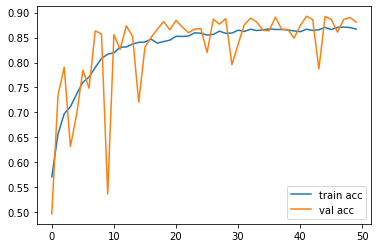

686/686 [==============================] - 1s 2ms/step - loss: 0.2830 - accuracy: 0.8809
Accuracy of model is 0.8809230923652649


In [64]:
#plot loss per iteration
plt.plot(model_history.history['loss'], label = 'train loss')
plt.plot(model_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

#accuracy per iteration
plt.plot(model_history.history['accuracy'], label = 'train acc')
plt.plot(model_history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();

acc_ann = model4.evaluate(Xtest, ytest)[1]

print(f'Accuracy of model is {acc_ann}')

Random Forest model will yield higher acc

Compared with Original data

In [68]:
raw = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [69]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [75]:
cate = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [76]:
raw = pd.get_dummies(raw, columns=cate)

In [77]:
raw['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [78]:
#create two different dataframe of majority and minority class 
df_majority = df[(df['y']== 'no')] 
df_minority = df[(df['y']== 'yes')] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 36548, # to match majority class
                                 random_state = 157)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled, df_majority])

In [80]:
df['y'].value_counts()

yes    36548
no     36544
Name: y, dtype: int64

In [81]:
features = df.drop(columns = 'y')
subscribe = df['y']
subscribe = subscribe.map(dict(yes=1, no=0))

Xtrain, Xtest, ytrain, ytest = train_test_split(features, subscribe, test_size=0.3, random_state=157)
Xtrain.shape, Xtest.shape

((51164, 52), (21928, 52))

Train acc: 0.9861426002658119
Test acc: 0.9501550529004014


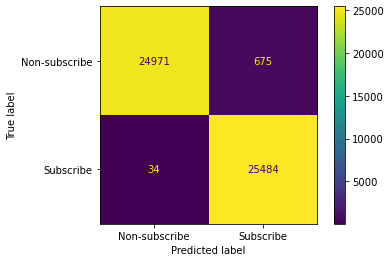

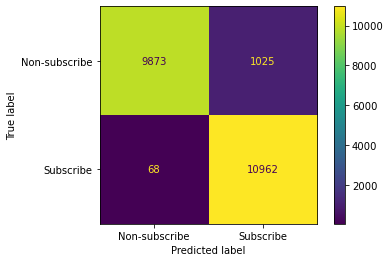

In [82]:
#random forest
model5 = RandomForestClassifier()

model5.fit(Xtrain, ytrain)

pred_train = model5.predict(Xtrain)
pred_test = model5.predict(Xtest)

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, 
                                          display_labels = ['Non-subscribe','Subscribe'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, 
                                         display_labels = ['Non-subscribe','Subscribe'])
cm_display_test.plot()

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))